# Reconhecimento de digitos usando MLP e CNN 

### Aprendizado de Máquina - Programa de Pós-Graduação em Automação e Sistemas - UFSC

### Professor Marcelo Ricardo Stemmer

### Alunos Andrei Donati e Angelo Baruffi 

**Reconhecimento de digitos (dataset MNIST) usando redes neurais comuns e redes neurais convulocionais no Keras**

As imagens estão disponíveis em www.kaggle.com/c/digit-recognizer/data e foram extraídas de um banco de dados da empresa de correios americana.
Depois de tratadas e regularizadas, as imagens foram disponibilizadas para uma competição no site Kaggle.com.

A apresentação fará a comparação de redes neurais para classificação dos digitos e utilizará a GPU para treinar a rede neural, melhorando o tempo de treinamento 

In [112]:
import tensorflow as tf
from keras import backend as K
import psutil
import os 
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras.utils import np_utils
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
K.set_image_dim_ordering('th')
import time

treinar = True
if not treinar:
    print('Será buscado o peso das redes no disco')
else:
    print('Todas as redes serão treinadas novamente')    

num_cores = psutil.cpu_count()
GPU= True

if GPU:
    num_GPU = 1
    num_CPU = 1
    print('Usando a GPU')
else:
    num_CPU = 1
    num_GPU = 0
    print('Usando apenas o CPU')

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)


Todas as redes serão treinadas novamente
Usando a GPU


## Dataset

Cada imagem tem 28 pixels de altura e 28 pixels de largura (784 pixels no total). Cada pixel tem um único valor (não é RGB, valor de 0 a 255), indicando a leveza ou a escuridão desse pixel.

O conjunto de dados de treino, possui 785 colunas. A primeira coluna, chamada "etiqueta", é o dígito que foi desenhado pelo usuário. O resto das colunas contém os valores de pixel da imagem associada.

In [114]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Exemplo de imagens

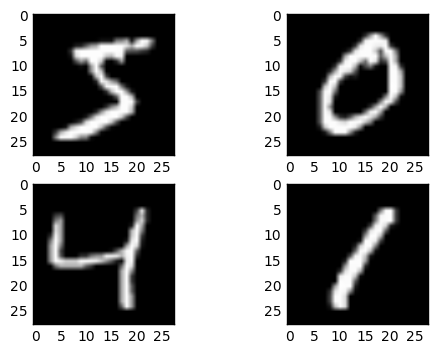

In [115]:
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
plt.show()

Mais alguns exemplos de digitos
<img src="http://corochann.com/wp-content/uploads/2017/02/mnist_plot.png">

Define uma seed padrão para garantir reproducibilidade

In [116]:
seed = 7
np.random.seed(seed)

### Conceitos das redes neurais

As redes MLP que vamos construir são similares aquelas estudadas em sala.

**Todas as redes desenvolvidas aqui tem 10 neurônios de saída, correspondente aos 10 digitos a serem reconhecidos **
<img src="https://www.researchgate.net/profile/Isik_Yilmaz/publication/252625657/figure/fig1/AS:298156324605965@1448097415988/Fig-1-Multi-layer-perceptron-neural-network.png">

Vamos utilizar a função de ativação Relu para deixar a rede não linear. 
Esta função é <img src="https://ml4a.github.io/images/figures/relu.png">

Como vamos utilizar alguns parâmetros não explorados em sala, segue uma conceituação destes:

**nb_epoch:**
Quantidade de vezes que os dados serão passados adiante (forward pass) e retropropagados (backward pass) pela redes 

**batch_size:**
Número de exemplos de treinamento que serão passados em um forward/backward pass 

#### Uma breve visualização sobre as redes neurais convolucionais que vamos utilizar mais abaixo 

Uma rede neural convolucional é formada por algumas camadas diferentes das redes comuns. 

São as camadas **Convolutional**, **MaxPoolling** e **DropOut**. 
As imagens a seguir nos ajudam a visualizar estas camadas
<img src="https://www.mathworks.com/content/mathworks/www/en/discovery/convolutional-neural-network/jcr:content/mainParsys/image_copy.adapt.full.high.jpg/1497876372993.jpg">

Camada de DropOut

<img src="http://cs231n.github.io/assets/nn2/dropout.jpeg">

## MLP  Básica

Importação, reshape e tratamento do dataset 

In [117]:
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

X_train = X_train / 255
X_test = X_test / 255

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

#### Construção do modelo de uma MLP
Modelo com:
- uma camada com 800 neurônios com função Relu de ativação
- camada de saída com 10 neurônios

In [118]:
def mlp():
    model = Sequential()
    model.add(Dense(800, input_dim=num_pixels, init='normal'))
    model.add(Activation('relu'))
    model.add(Dense(num_classes, init='normal'))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Executa o treinamento e o teste da rede neural

In [119]:
model = mlp()

start_time = time.time()

if treinar:
    print("Treinando a rede")
    model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200, verbose=2)
    model.save_weights("mlp.h5")
    print("Pesos salvos")
else:
    model.load_weights("mlp.h5")
    print("Pesos recuperados do disco")

scores = model.evaluate(X_test, y_test, verbose=0)

print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print("Rede treinada/buscada em %.2f segundos" % (time.time() - start_time))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
10s - loss: 0.2868 - acc: 0.9176 - val_loss: 0.1407 - val_acc: 0.9582
Epoch 2/10
5s - loss: 0.1112 - acc: 0.9676 - val_loss: 0.0906 - val_acc: 0.9730
Epoch 3/10
5s - loss: 0.0712 - acc: 0.9796 - val_loss: 0.0801 - val_acc: 0.9754
Epoch 4/10
6s - loss: 0.0499 - acc: 0.9857 - val_loss: 0.0765 - val_acc: 0.9762
Epoch 5/10
6s - loss: 0.0370 - acc: 0.9895 - val_loss: 0.0683 - val_acc: 0.9788
Epoch 6/10
5s - loss: 0.0267 - acc: 0.9927 - val_loss: 0.0663 - val_acc: 0.9792
Epoch 7/10
5s - loss: 0.0204 - acc: 0.9947 - val_loss: 0.0604 - val_acc: 0.9822
Epoch 8/10
5s - loss: 0.0134 - acc: 0.9973 - val_loss: 0.0608 - val_acc: 0.9809
Epoch 9/10
5s - loss: 0.0106 - acc: 0.9978 - val_loss: 0.0557 - val_acc: 0.9827
Epoch 10/10
5s - loss: 0.0079 - acc: 0.9986 - val_loss: 0.0571 - val_acc: 0.9837
Pesos salvos
Baseline Error: 1.63%
Rede treinada/buscada em 61.90 segundos


Encontra as imagens que ele classificou errado

In [120]:
pred = model.predict(X_test, verbose=0)
pred = np.argmax(pred, axis=1)
labels = np.argmax(y_test, axis=1)
wrong_class = [i for i in range(pred.size) if pred[i]!=labels[i]]

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Plot das imagens que ele classificou errado

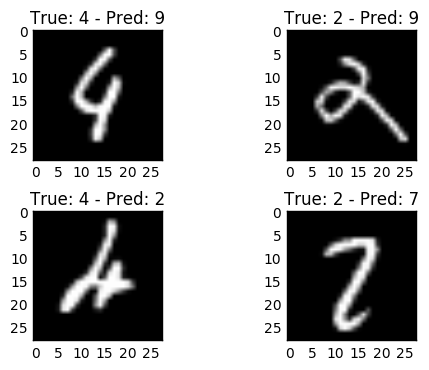

In [33]:
plt.subplot(221).set_title("True: "+ str(labels[wrong_class[0]])+ " - Pred: " + str(pred[wrong_class[0]]) )
plt.imshow(X_test[wrong_class[0]], cmap=plt.get_cmap('gray'))
plt.subplot(222).set_title("True: "+ str(labels[wrong_class[1]])+ " - Pred: " + str(pred[wrong_class[1]]) )
plt.imshow(X_test[wrong_class[1]], cmap=plt.get_cmap('gray'))
plt.subplot(223).set_title("True: "+ str(labels[wrong_class[2]])+ " - Pred: " + str(pred[wrong_class[2]]) )
plt.imshow(X_test[wrong_class[2]], cmap=plt.get_cmap('gray'))
plt.subplot(224).set_title("True: "+ str(labels[wrong_class[3]])+ " - Pred: " + str(pred[wrong_class[3]]) )
plt.imshow(X_test[wrong_class[3]], cmap=plt.get_cmap('gray'))
plt.subplots_adjust(hspace=0.4)
plt.show()

#### Conclusão sobre o modelo: 
Apesar de simples, a rede apresenta um desempenho bem interessante para o problema

## MLP Deep

Importação, reshape e tratamento do dataset

In [121]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

X_train = X_train / 255
X_test = X_test / 255

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

#### Construção do modelo de uma mlp deep.

Modelo com:
- uma camada com 800 neurônios com função Relu de ativação
- uma camada com 400 neurônios com função Relu de ativação
- camada de saída com 10 neurônios

In [122]:
def mlp_deep():
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, init='normal'))
    model.add(Activation('relu'))
    model.add(Dense(800, input_dim=num_pixels, init='normal'))
    model.add(Activation('relu'))
    model.add(Dense(400, input_dim=num_pixels, init='normal'))
    model.add(Activation('relu'))
    model.add(Dense(num_classes, init='normal'))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Executa o treinamento e o teste da rede neural

In [123]:
model = mlp_deep()

start_time = time.time()

if treinar:
    print("Treinando a rede")
    model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=15, batch_size=200, verbose=2)
    model.save_weights("mlp_deep.h5")
    print("Pesos salvos")
else:
    model.load_weights("mlp_deep.h5")
    print("Pesos recuperados do disco")
    
scores = model.evaluate(X_test, y_test, verbose=0)

print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print("Rede treinada/buscada em %.2f segundos" % (time.time() - start_time))

Treinando a rede
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
11s - loss: 0.2124 - acc: 0.9367 - val_loss: 0.0947 - val_acc: 0.9703
Epoch 2/15
10s - loss: 0.0761 - acc: 0.9760 - val_loss: 0.0746 - val_acc: 0.9764
Epoch 3/15
10s - loss: 0.0490 - acc: 0.9842 - val_loss: 0.0722 - val_acc: 0.9782
Epoch 4/15
10s - loss: 0.0357 - acc: 0.9881 - val_loss: 0.0711 - val_acc: 0.9800
Epoch 5/15
10s - loss: 0.0286 - acc: 0.9905 - val_loss: 0.0738 - val_acc: 0.9786
Epoch 6/15
10s - loss: 0.0223 - acc: 0.9924 - val_loss: 0.0761 - val_acc: 0.9802
Epoch 7/15
10s - loss: 0.0208 - acc: 0.9932 - val_loss: 0.0976 - val_acc: 0.9749
Epoch 8/15
10s - loss: 0.0156 - acc: 0.9949 - val_loss: 0.0853 - val_acc: 0.9808
Epoch 9/15
10s - loss: 0.0147 - acc: 0.9953 - val_loss: 0.0901 - val_acc: 0.9796
Epoch 10/15
10s - loss: 0.0175 - acc: 0.9944 - val_loss: 0.0968 - val_acc: 0.9799
Epoch 11/15
10s - loss: 0.0163 - acc: 0.9945 - val_loss: 0.0917 - val_acc: 0.9772
Epoch 12/15
10s - loss: 0.0114 - acc: 0.

Encontra as imagens que ele classificou errado

In [124]:
pred = model.predict(X_test, verbose=0)
pred = np.argmax(pred, axis=1)
labels = np.argmax(y_test, axis=1)
wrong_class = [i for i in range(pred.size) if pred[i]!=labels[i]]

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Plot das imagens que ele classificou errado

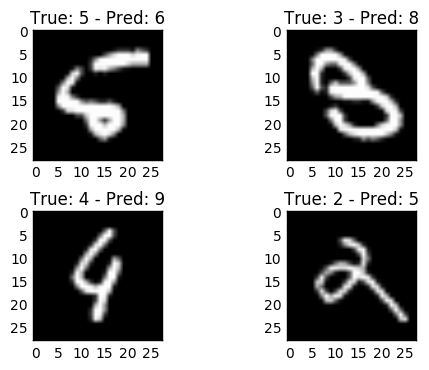

In [125]:
plt.subplot(221).set_title("True: "+ str(labels[wrong_class[0]])+ " - Pred: " + str(pred[wrong_class[0]]) )
plt.imshow(X_test[wrong_class[0]], cmap=plt.get_cmap('gray'))
plt.subplot(222).set_title("True: "+ str(labels[wrong_class[1]])+ " - Pred: " + str(pred[wrong_class[1]]) )
plt.imshow(X_test[wrong_class[1]], cmap=plt.get_cmap('gray'))
plt.subplot(223).set_title("True: "+ str(labels[wrong_class[2]])+ " - Pred: " + str(pred[wrong_class[2]]) )
plt.imshow(X_test[wrong_class[2]], cmap=plt.get_cmap('gray'))
plt.subplot(224).set_title("True: "+ str(labels[wrong_class[3]])+ " - Pred: " + str(pred[wrong_class[3]]) )
plt.imshow(X_test[wrong_class[3]], cmap=plt.get_cmap('gray'))
plt.subplots_adjust(hspace=0.4)
plt.show()

#### Conclusão sobre o modelo: 
Mesmo sendo mais complexa e demorada para treinar, tem um desempenho bem pior que a outra rede. A rede está apresentando overfitting, o que poderia ser utilizado um layer de dropout para ajudar

## CNN básica

Importação, reshape e tratamento do dataset

In [151]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

X_train = X_train / 255
X_test = X_test / 255

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

#### Construção do modelo de uma uma simples CNN.

Modelo com:
- uma camada de convolução de 32 filtros de 5x5
- uma camada de Pooling 2x2 com a função max()
- uma camada de DropOut de 20% dos neurônios
- uma camada com 128 neurônios com função Relu de ativação, estilo MLP
- camada de saída com 10 neurônios


In [152]:
def simple_ccn():
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


Executa o treinamento e o teste da rede neural

In [156]:
model = simple_ccn()

start_time = time.time()

if treinar:
    print("Treinando a rede")
    model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=12, batch_size=200, verbose=2)    
    model.save_weights("simple_ccn.h5")
    print("Pesos salvos")
else:
    model.load_weights("simple_ccn.h5")
    print("Pesos recuperados do disco")

scores = model.evaluate(X_test, y_test, verbose=0)

print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print("Rede treinada/buscada em %.2f segundos" % (time.time() - start_time))

Treinando a rede
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
36s - loss: 0.2472 - acc: 0.9294 - val_loss: 0.0908 - val_acc: 0.9724
Epoch 2/12
35s - loss: 0.0752 - acc: 0.9776 - val_loss: 0.0532 - val_acc: 0.9827
Epoch 3/12
35s - loss: 0.0549 - acc: 0.9831 - val_loss: 0.0474 - val_acc: 0.9838
Epoch 4/12
35s - loss: 0.0424 - acc: 0.9865 - val_loss: 0.0417 - val_acc: 0.9860
Epoch 5/12
35s - loss: 0.0355 - acc: 0.9890 - val_loss: 0.0358 - val_acc: 0.9875
Epoch 6/12
35s - loss: 0.0298 - acc: 0.9904 - val_loss: 0.0342 - val_acc: 0.9883
Epoch 7/12
35s - loss: 0.0255 - acc: 0.9917 - val_loss: 0.0347 - val_acc: 0.9879
Epoch 8/12
35s - loss: 0.0209 - acc: 0.9932 - val_loss: 0.0363 - val_acc: 0.9878
Epoch 9/12
35s - loss: 0.0192 - acc: 0.9938 - val_loss: 0.0318 - val_acc: 0.9893
Epoch 10/12
35s - loss: 0.0140 - acc: 0.9954 - val_loss: 0.0322 - val_acc: 0.9898
Epoch 11/12
35s - loss: 0.0133 - acc: 0.9953 - val_loss: 0.0339 - val_acc: 0.9893
Epoch 12/12
35s - loss: 0.0116 - acc: 0.

Encontra as imagens que ele classificou errado

In [139]:
pred = model.predict(X_test, verbose=0)
pred = np.argmax(pred, axis=1)
labels = np.argmax(y_test, axis=1)
wrong_class = [i for i in range(pred.size) if pred[i]!=labels[i]]

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Plot das imagens que ele classificou errado

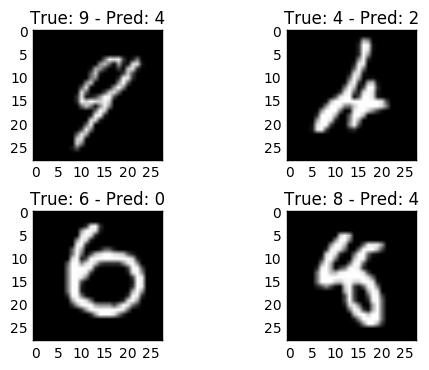

In [140]:
plt.subplot(221).set_title("True: "+ str(labels[wrong_class[0]])+ " - Pred: " + str(pred[wrong_class[0]]) )
plt.imshow(X_test[wrong_class[0]], cmap=plt.get_cmap('gray'))
plt.subplot(222).set_title("True: "+ str(labels[wrong_class[1]])+ " - Pred: " + str(pred[wrong_class[1]]) )
plt.imshow(X_test[wrong_class[1]], cmap=plt.get_cmap('gray'))
plt.subplot(223).set_title("True: "+ str(labels[wrong_class[2]])+ " - Pred: " + str(pred[wrong_class[2]]) )
plt.imshow(X_test[wrong_class[2]], cmap=plt.get_cmap('gray'))
plt.subplot(224).set_title("True: "+ str(labels[wrong_class[3]])+ " - Pred: " + str(pred[wrong_class[3]]) )
plt.imshow(X_test[wrong_class[3]], cmap=plt.get_cmap('gray'))
plt.subplots_adjust(hspace=0.4)
plt.show()

#### Conclusão sobre o modelo: 
Rede que apresenta um desempenho muito bom, como o esperado para redes CNNs, porém tem grande tempo de treinamento

## CNN Larger

Importação, reshape e tratamento do dataset

In [76]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

X_train = X_train / 255
X_test = X_test / 255

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

#### Construção do modelo de uma uma simples CNN.

Modelo com:
- uma camada de convolução de 32 filtros de 5x5
- uma camada de Pooling 2x2 com a função max()
- uma camada de DropOut de 20% dos neurônios
- uma camada de convolução de 15 filtros de 3x3
- uma camada de Pooling 2x2 com a função max()
- uma camada de DropOut de 20% dos neurônios
- uma camada com 128 neurônios com função Relu de ativação, estilo MLP
- uma camada com 50 neurônios com função Relu de ativação, estilo MLP
- camada de saída com 10 neurônios

In [77]:
def cnn_larger():
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(15, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [78]:
model = cnn_larger()

start_time = time.time()

if treinar:
    print("Treinando a rede")
    model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200)
    model.save_weights("cnn_larger.h5")
    print("Pesos salvos")
else:
    model.load_weights("cnn_larger.h5")
    print("Pesos recuperados do disco")

scores = model.evaluate(X_test, y_test, verbose=0)

print("Large CNN Error: %.2f%%" % (100-scores[1]*100))
print("Rede treinada/buscada em %.2f segundos" % (time.time() - start_time))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 38s - loss: 0.4103 - acc: 0.8701 - val_loss: 0.0936 - val_acc: 0.9708
Epoch 2/10
60000/60000 [==============================] - 38s - loss: 0.0971 - acc: 0.9705 - val_loss: 0.0476 - val_acc: 0.9855
Epoch 3/10
60000/60000 [==============================] - 38s - loss: 0.0680 - acc: 0.9791 - val_loss: 0.0404 - val_acc: 0.9871
Epoch 4/10
60000/60000 [==============================] - 39s - loss: 0.0548 - acc: 0.9831 - val_loss: 0.0351 - val_acc: 0.9877
Epoch 5/10
60000/60000 [==============================] - 38s - loss: 0.0475 - acc: 0.9854 - val_loss: 0.0376 - val_acc: 0.9877
Epoch 6/10
60000/60000 [==============================] - 38s - loss: 0.0431 - acc: 0.9863 - val_loss: 0.0265 - val_acc: 0.9916
Epoch 7/10
60000/60000 [==============================] - 38s - loss: 0.0376 - acc: 0.9881 - val_loss: 0.0262 - val_acc: 0.9911
Epoch 8/10
60000/60000 [==============================

Encontra as imagens que ele classificou errado

In [82]:
pred = model.predict(X_test, verbose=0)
pred = np.argmax(pred, axis=1)
labels = np.argmax(y_test, axis=1)
wrong_class = [i for i in range(pred.size) if pred[i]!=labels[i]]

(X_train, y_train), (X_test, y_test) = mnist.load_data()

FailedPreconditionError: Attempting to use uninitialized value convolution2d_19_W
	 [[Node: convolution2d_19_W/read = Identity[T=DT_FLOAT, _class=["loc:@convolution2d_19_W"], _device="/job:localhost/replica:0/task:0/gpu:0"](convolution2d_19_W)]]
	 [[Node: Softmax_16/_13 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_68_Softmax_16", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'convolution2d_19_W/read', defined at:
  File "C:\Users\Andrei\Anaconda3\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Andrei\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\traitlets\config\application.py", line 653, in launch_instance
    app.start()
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-78-e0ca88df45ef>", line 1, in <module>
    model = cnn_larger()
  File "<ipython-input-77-b04bb759522c>", line 3, in cnn_larger
    model.add(Convolution2D(32, 5, 5, input_shape=(1, 28, 28), activation='relu'))
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\keras\models.py", line 294, in add
    layer.create_input_layer(batch_input_shape, input_dtype)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\keras\engine\topology.py", line 398, in create_input_layer
    self(x)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\keras\engine\topology.py", line 543, in __call__
    self.build(input_shapes[0])
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\keras\layers\convolutional.py", line 403, in build
    constraint=self.W_constraint)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\keras\engine\topology.py", line 415, in add_weight
    weight = initializer(shape, name=name)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\keras\initializations.py", line 60, in glorot_uniform
    return uniform(shape, s, name=name)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\keras\initializations.py", line 33, in uniform
    return K.random_uniform_variable(shape, -scale, scale, name=name)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 620, in random_uniform_variable
    return variable(value, dtype=dtype, name=name)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 248, in variable
    v = tf.Variable(value, dtype=_convert_string_dtype(dtype), name=name)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 224, in __init__
    expected_shape=expected_shape)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 370, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1424, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value convolution2d_19_W
	 [[Node: convolution2d_19_W/read = Identity[T=DT_FLOAT, _class=["loc:@convolution2d_19_W"], _device="/job:localhost/replica:0/task:0/gpu:0"](convolution2d_19_W)]]
	 [[Node: Softmax_16/_13 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_68_Softmax_16", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


Plot das imagens que ele classificou errado

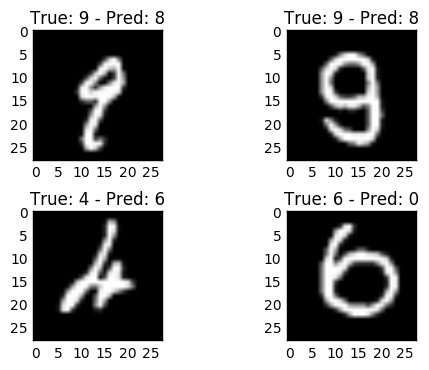

In [24]:
plt.subplot(221).set_title("True: "+ str(labels[wrong_class[0]])+ " - Pred: " + str(pred[wrong_class[0]]) )
plt.imshow(X_test[wrong_class[0]], cmap=plt.get_cmap('gray'))
plt.subplot(222).set_title("True: "+ str(labels[wrong_class[1]])+ " - Pred: " + str(pred[wrong_class[1]]) )
plt.imshow(X_test[wrong_class[1]], cmap=plt.get_cmap('gray'))
plt.subplot(223).set_title("True: "+ str(labels[wrong_class[2]])+ " - Pred: " + str(pred[wrong_class[2]]) )
plt.imshow(X_test[wrong_class[2]], cmap=plt.get_cmap('gray'))
plt.subplot(224).set_title("True: "+ str(labels[wrong_class[3]])+ " - Pred: " + str(pred[wrong_class[3]]) )
plt.imshow(X_test[wrong_class[3]], cmap=plt.get_cmap('gray'))
plt.subplots_adjust(hspace=0.4)
plt.show()

#### Conclusão sobre o modelo: 
Rede com desempenho muito bom (próximo do Estado da Arte), porém com altíssima necessidade de desempenho computacional

## Código disponível em https://github.com/andrei258258/reconhecimento-digitos-MNIST

## Referências

www.kaggle.com/c/digit-recognizer - Acessado em 24 de setembro de 2017

machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/ - Acessado em 24 de setembro de 2017
